In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_style_sheet
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from scipy.stats import linregress
import numpy as np
import random
import vice
import sys
sys.path.append("..")
from src.stats import skewnormal_mode_sample, jackknife_summary_statistic
load_style_sheet("papers")
# load_mpl_presets()
# mpl.rcParams["axes.linewidth"] = 0.5
# mpl.rcParams["figure.titlesize"] = 14
# mpl.rcParams["axes.titlesize"] = 14
# mpl.rcParams["axes.labelsize"] = 14
# mpl.rcParams["xtick.labelsize"] = 14
# mpl.rcParams["ytick.labelsize"] = 14
# mpl.rcParams["legend.fontsize"] = 14
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)


In [17]:
output = "../outputs/outer-burst/eta-eR/yieldsolar3"
output = vice.output(output)

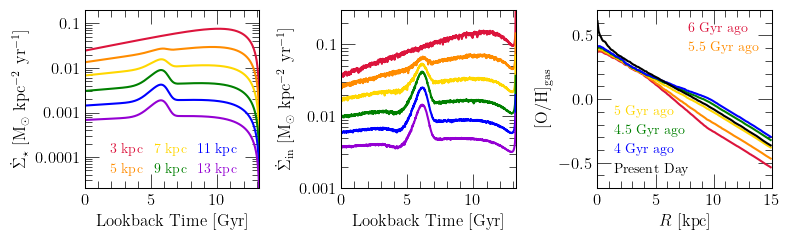

In [52]:
RADII = [3, 5, 7, 9, 11, 13]
RADII_COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
LOOKBACKS = [6, 5.5, 5, 4.5, 4, 0]
LOOKBACKS_COLORS = ["crimson", "darkorange", "gold", "green", "blue", "black"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (8, 2.5))
axes = []
for i in range(3): axes.append(fig.add_subplot(131 + i))
axes[0].set_xlabel(r"Lookback Time [Gyr]")
axes[0].set_ylabel(r"$\dot{\Sigma}_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[0].set_xlim([0, 13.2])
axes[0].set_ylim([2e-5, 0.2])
axes[0].set_yscale("log")
axes[0].yaxis.set_major_formatter(fsf("%g"))
axes[1].set_xlabel(r"Lookback Time [Gyr]")
axes[1].set_ylabel(r"$\dot{\Sigma}_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[1].set_xlim([0, 13.2])
axes[1].set_ylim([1e-3, 0.3])
axes[1].set_yscale("log")
axes[1].yaxis.set_major_formatter(fsf("%g"))
axes[2].set_xlabel(r"$R$ [kpc]")
axes[2].set_ylabel(r"[O/H]$_\text{gas}$")
axes[2].set_xlim([0, 15])
axes[2].set_ylim([-0.7, 0.7])

def plot_sfh(ax, output, radius, **kwargs):
    zone = int(radius / ZONE_WIDTH)
    zone = output.zones["zone%d" % (zone)]
    area = np.pi * ((radius + ZONE_WIDTH)**2 - radius**2)
    sfh = [s / area for s in zone.history["sfr"]]
    return ax.plot(zone.history["lookback"], sfh, **kwargs)

def plot_ifh(ax, output, radius, **kwargs):
    zone = int(radius / ZONE_WIDTH)
    zone = output.zones["zone%d" % (zone)]
    area = np.pi * ((radius + ZONE_WIDTH)**2 - radius**2)
    ifh = [i / area for i in zone.history["ifr"]]
    return ax.plot(zone.history["lookback"], ifh, **kwargs)

def plot_gradient_snapshot(ax, output, lookback, element = "o", **kwargs):
    radii = np.arange(ax.get_xlim()[0], ax.get_xlim()[1], ZONE_WIDTH)
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    xh = []
    for i in range(len(radii)): xh.append(
        output.zones["zone%d" % (i)].history["[%s/h]" % (element)][idx])
    return ax.plot(radii, xh, **kwargs)

for i in range(len(RADII)):
    kwargs = {
        "c": named_colors()[RADII_COLORS[i]],
        "label": r"$%d$ kpc" % (RADII[i])
    }
    plot_sfh(axes[0], output, RADII[i], **kwargs)
    plot_ifh(axes[1], output, RADII[i], **kwargs)

handles = []
labels = []
for i in range(len(LOOKBACKS)):
    kwargs = {"c": named_colors()[LOOKBACKS_COLORS[i]]}
    if LOOKBACKS[i]:
        labels.append(r"$%g$ Gyr ago" % (LOOKBACKS[i]))
    else:
        labels.append("Present Day")
    handles.append(plot_gradient_snapshot(axes[2], output, LOOKBACKS[i], **kwargs)[0])

legend_break = 2
kwargs = {
    "loc": mpl_loc("upper right"),
    "ncol": 1,
    "handlelength": 0,
    "fontsize": 10
}
leg = axes[2].legend(handles[:legend_break], labels[:legend_break], **kwargs)
fancy_legend(leg, LOOKBACKS_COLORS[:legend_break])
axes[2].add_artist(leg)
kwargs["loc"] = mpl_loc("lower left")
leg = axes[2].legend(handles[legend_break:], labels[legend_break:], **kwargs)
fancy_legend(leg, LOOKBACKS_COLORS[legend_break:])

kwargs = {
    "loc": mpl_loc("lower center"),
    "ncol": 3,
    "handlelength": 0,
    "columnspacing": 0.5,
    "fontsize": 10
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, RADII_COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./perturbative/outerburst-evol.%s" % (ext), **kwargs)
plt.show()

In [16]:
output = "../outputs/inside-out/eta-eR/yieldsolar3-etaevol"
output = vice.output(output)

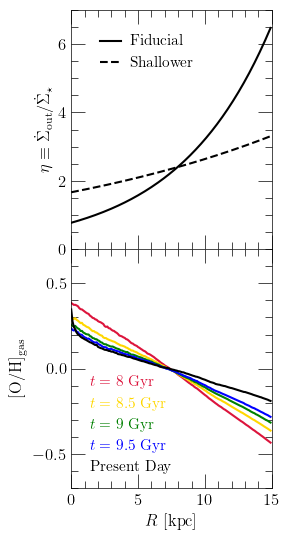

In [36]:
ELEMENT = "O"
SNAPSHOTS = [8, 8.5, 9, 9.5, 13.2]
COLORS = ["crimson", "gold", "green", "blue", "black"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (3, 5.5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)
plt.setp(ax1.get_xticklabels(), visible = False)
ax1.set_ylabel(r"$\eta \equiv \dot{\Sigma}_\text{out} / \dot{\Sigma}_\star$")
ax2.set_xlabel(r"$R$ [kpc]")
ax2.set_ylabel(r"[%s/H]$_\text{gas}$" % (ELEMENT.capitalize()))
ax1.set_xlim([0, 15])
ax1.set_ylim([0, 7])
ax1.set_yticks([0, 2, 4, 6])
ax2.set_ylim([-0.7, 0.7])
ax2.set_yticks([-0.5, 0, 0.5])

def plot_snapshot(ax, output, time, **kwargs):
    diff = [abs(time - _) for _ in output.zones["zone0"].history["time"]]
    idx = diff.index(min(diff))
    radii = np.arange(ax.get_xlim()[0], ax.get_xlim()[1], ZONE_WIDTH)
    xh = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        xh.append(zone.history["[%s/h]" % (ELEMENT)][idx])
    ax.plot(radii, xh, **kwargs)

def plot_eta(ax, output, time, **kwargs):
    diff = [abs(time - _) for _ in output.zones["zone0"].history["time"]]
    idx = diff.index(min(diff))
    radii = np.arange(ax.get_xlim()[0], ax.get_xlim()[1], ZONE_WIDTH)
    eta = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        eta.append(zone.history["eta_0"][idx])
    ax.plot(radii, eta, **kwargs)

plot_eta(ax1, output, 5, c = named_colors()["black"], label = "Fiducial")
plot_eta(ax1, output, 10, c = named_colors()["black"], linestyle = "--", label = "Shallower")
for i in range(len(SNAPSHOTS)):
    kwargs = {"c": named_colors()[COLORS[i]]}
    if SNAPSHOTS[i] == 13.2:
        kwargs["label"] = "Present Day"
    else:
        kwargs["label"] = r"$t = %g$ Gyr" % (SNAPSHOTS[i])
    plot_snapshot(ax2, output, SNAPSHOTS[i], **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (0.05, 0.95),
    "fontsize": 11
}
ax1.legend(**kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "fontsize": 11
}
leg = ax2.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./perturbative/eta-sudden-change.%s" % (ext), **kwargs)
plt.show()